# Vegetation mortality and burn severity in the 2018 Woolsey Fire in southern California

__Adam Mansur and Michael Sutherland__<br>
__Project mentors: Natasha Stavros and Joe McGlinchy__<br>
__Spring 2021__

In [2]:
# Import required Python libraries needed for blog post

import os
from pathlib import Path

import contextily as ctx
import earthpy.plot as ep
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import rioxarray as rxr 
import seaborn as sns

from config import CRS, DATA_DIR
from utils import load_nifc_fires
from utils_xr import open_raster, plot_bands, reproject_match




# Set working directory to repo data directory
os.chdir(DATA_DIR)

In [3]:
# Load Woolsey Fire perimeter shapefile
woolsey_fire = gpd.read_file(
    os.path.join("woolsey_fire_shapefile", "2018-CAVNC-091023.shp"))
crop_bound = woolsey_fire.geometry

# Load Santa Monica Mountain (SMM) vegetation community data
smm_veg_comm = open_raster(
    "smm_veg_comm.tif",
    crs=CRS,
    crop_bound=crop_bound
)

# Load Santa Monica Mountain (SMM) fraction-alive data
smm_fal = open_raster(
    "smm_fal_2013_2016.tif",
    crs=CRS,
    crop_bound=crop_bound
)

# Load and reproject MTBS classified dNBR
dnbr_classified = open_raster(
    "mtbs_woolsey_fire_dnbr.tif",
    crs=CRS,
    crop_bound=crop_bound)
dnbr_classified = dnbr_classified.where(dnbr_classified != -9999, np.nan)
dnbr_classified = reproject_match(dnbr_classified, smm_veg_comm)

## Project Overview

Over two weeks in November 2018, the Woolsey Fire burned nearly 100,000 acres in the Santa Monica Mountains north of Malibu, California (Fig. 1). Three people were killed in the fire and over 1,600 structures were destroyed. Two other fires that ignited the same day as the Woolsey Fire caused widespread damage throughout California.

In [5]:
# Create basemap of the Woolsey Fire scar
bs_plt = woolsey_fire.to_crs(epsg=3857)
ax = bs_plt.plot(alpha=0.2, color='red', figsize=(12, 12))
ctx.add_basemap(ax)
ax.set_title("Woolsey Fire Basemap")

Text(0.5, 1.0, 'Woolsey Fire Basemap')

__Figure 1. Woolsey Fire burn scar overview map.__

Wildfires like the Woolsey Fire pose an increasing threat to life, property and ecosystems in the American West. Larger fires and longer fire seasons stress emergency response personnel and budgets while more people move into the urban-wildland interface where fires are more likely. Understanding the factors that drive wildfires may allow authorities better manage them, mitigating some risks in the fire-prone West.

Drought influences fire severity by drying out soil and killing vegetation that can serve as fuel. The Woolsey Fire was preceded by a four-year drought (2013-2016) that resulted in a significant dieback of grass, shrubs, and trees throughout California. How did that dieback influence the spread and severity of the Woolsey Fire? 

In this project, we will examine the relationship between vegetation mortality and burn severity during the Woolsey Fire by using a machine-learning approach to analyze pre- and post-fire satellite imagery. We plan to test the following hypotheses:

+ Areas with greater vegetation mortality will show worse burn severity
+ Areas with older vegetation mortality will show worse burn severity

## Data sources

This study leverages data collected for an earlier survey of the 2013-2016 drought (Table 1). That study's authors used high-resolution data from NASA's AVIRIS sensor to create vegetation community (Fig. 2) and fraction-alive (FAL) maps (Fig. 3) that document the health of the vegetation in the area later burned by the Woolsey Fire. They also compiled 4-km weather data to understand how different communities reacted to the prolonged drought. Using the FAL data, we also calculated fraction-alive difference (dFAL) plots to quantify changes in vegetation mortality during each year of the California drought.

#### Table 1. Data Sources 
| Data Type | Source | Description | Source Spatial Resolution |
| :--- | :--- | :---: | :---: |
| Vegetation Community | NASA | Classified vegetation communities;<br> derived from AVIRIS sensor data | 15.6 m | 
| Relative Fraction Alive (RFAL) | NASA | Proxy for healthy vegetation;<br> time series from 2013-16 | 15.6 m | 
| Difference Normalized Burned Ratio (dNBR) | MTBS | Indicator of burn severity; derived from <br> Sentinel-2 data from 2017 and 2018 | 30 m | 
| Digital Elevation Model (DEM) | USGS | Elevation data for characterizing terrain;<br>used to create derivatives such as slope and aspect | 1 m | 
| Weather | NRCS | Data layers obtained include Days of Precipitation, <br> Vapor Pressure Deficit, Minimum Temperature, <br> Days over 95 Degrees, Cumulative Precipitation. <br> These data represent annual aggregates for the years 2013-2016. | 4 km | 

In [5]:
# Make vegetation community plot
labels = [
    "No data",
    "Annual grass",
    "Chaparral",
    "Coastal sage scrub",
    "Oak woodland",
    "Riparian",
    "Substrate"
]

colors = [
    "white",
    "tab:green",
    "tab:olive",
    "tab:cyan",
    "tab:red",
    "tab:blue",
    "lightgray"
]

# Draw plot
fig, ax = plt.subplots(figsize=(10, 10))
plot_bands(smm_veg_comm,
           ax=ax,
           title="Vegetation community map - Woolsey Fire - 15.6 m",
           cmap=ListedColormap(colors),
           cbar=False)
woolsey_fire.plot(ax=ax, edgecolor="k", facecolor="none", linewidth=2)

# Draw legend
ep.draw_legend(ax.get_images()[0], 
               titles=labels,
               classes=range(len(labels)))

__Figure 2. Vegetation Classification Data within the Woolsey Fire burn scar.__

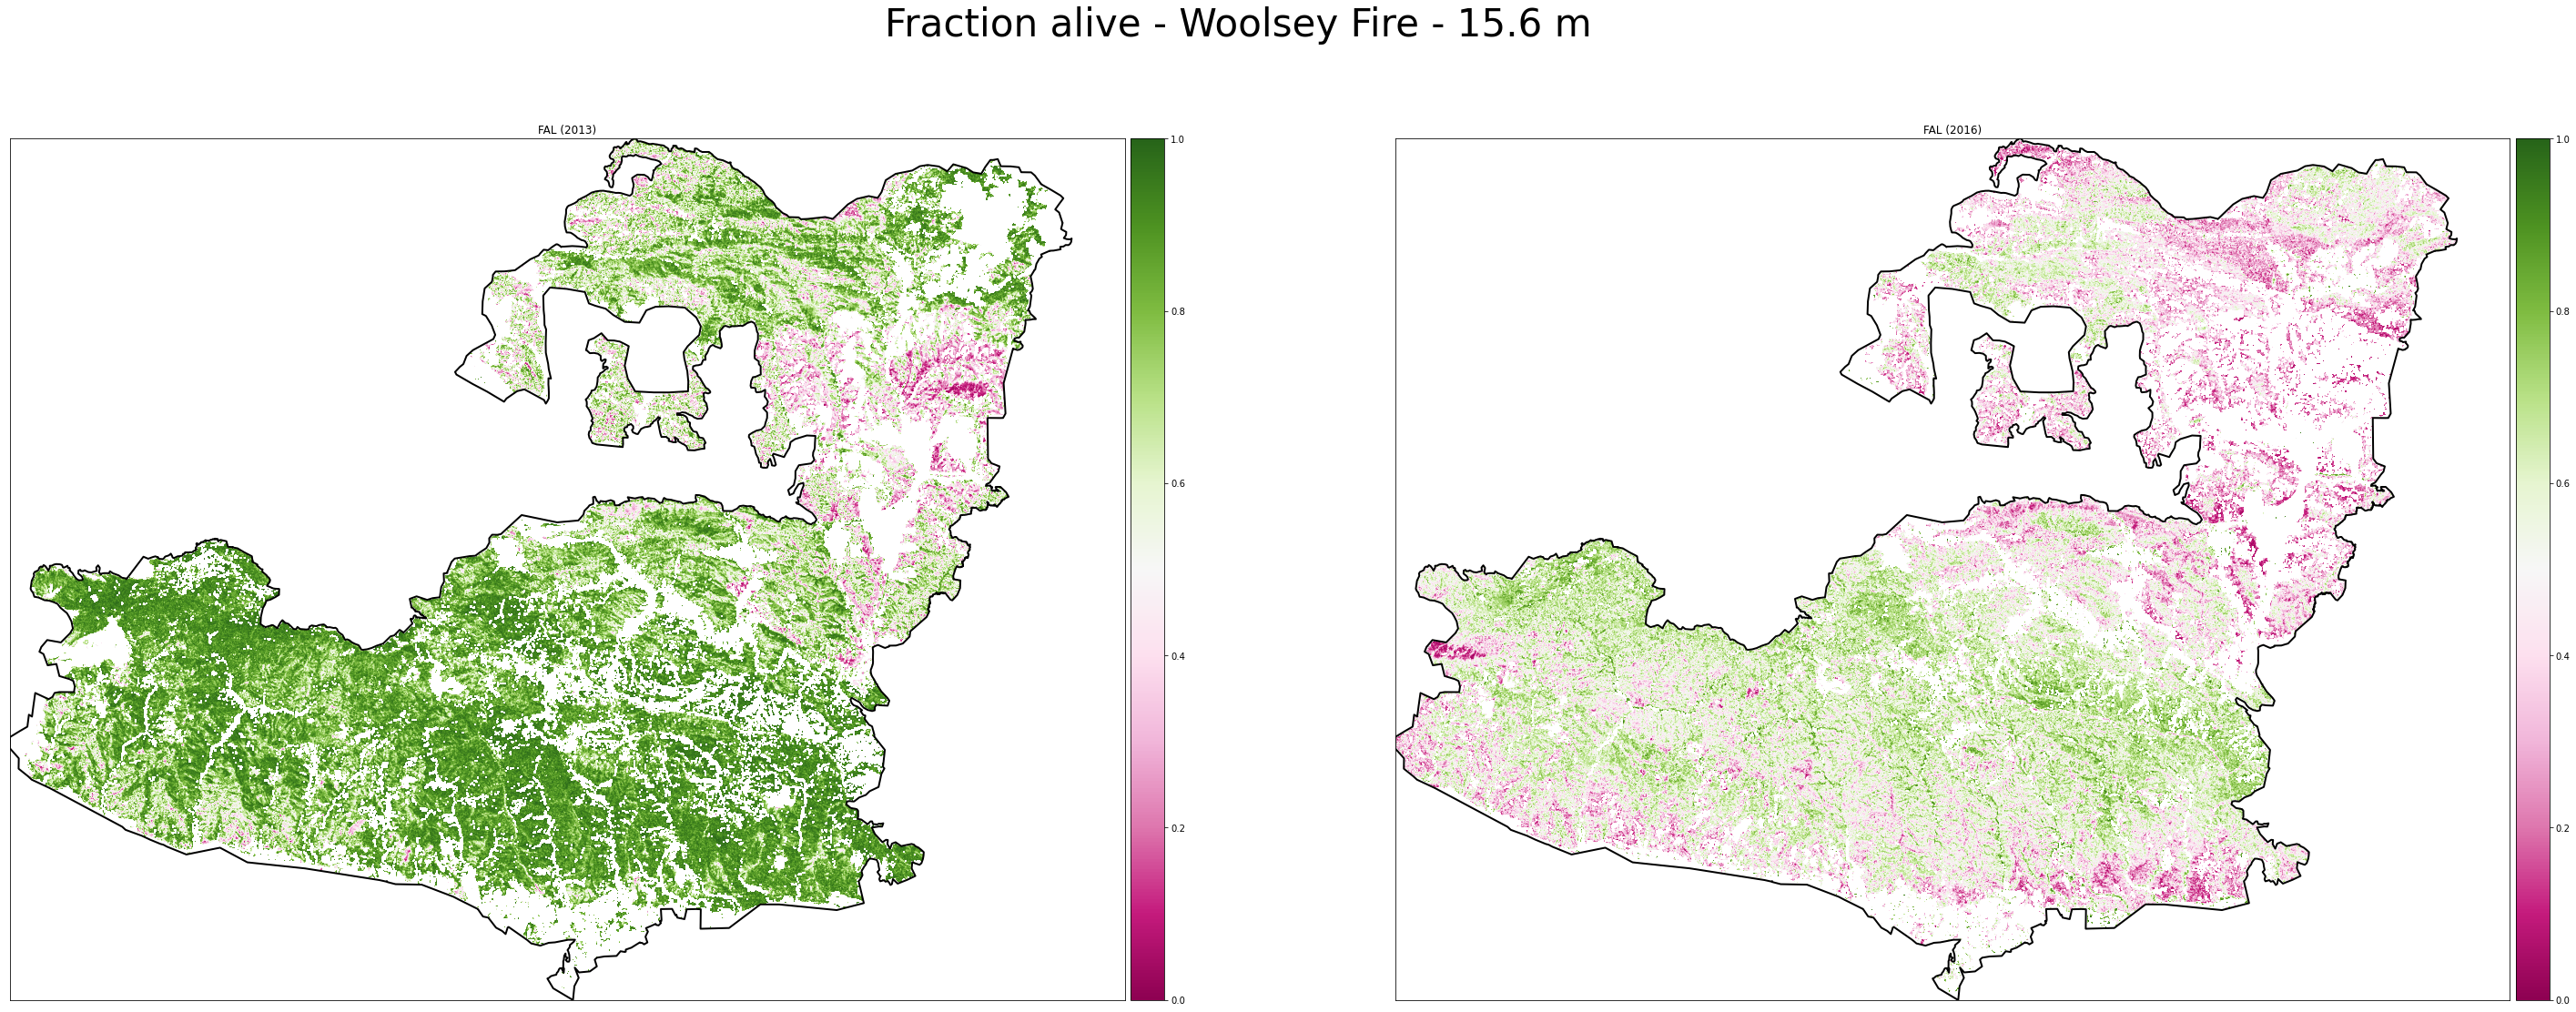

In [6]:
# Make fraction alive plot

# Reclip the FAL data. This should already have been handled above, but
# if this step is omitted the background shows up as pink, not white.
smm_fal = smm_fal.rio.clip(woolsey_fire.geometry)

# The nodata value for the FAL plots is -3.40282306e+38, but that is not set
# on the source file. All other values are between 0 and 1.
smm_fal = smm_fal.where(smm_fal >= 0, np.nan)

# Image has to be big or the interpolation is terrible
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(50, 18))
fig.suptitle("Fraction alive - Woolsey Fire - 15.6 m", fontsize=42)

plot_bands(smm_fal[0], ax=ax1, cmap="PiYG", vmin=0, vmax=1, title="FAL (2013)")
plot_bands(smm_fal[3], ax=ax2, cmap="PiYG", vmin=0, vmax=1, title="FAL (2016)")

for ax in (ax1, ax2):
    woolsey_fire.plot(ax=ax, edgecolor="k", facecolor="none", linewidth=2)
    
#plt.tight_layout()

__Figure 3. Fraction Alive Rasters, 2013 (left) and 2016 (right). These data are a proxy for the presence of healthy green vegetation.__

We are also using burn severity data for the Woolsey Fire from Monitoring Trends in Burn Severity (MTBS), an interagency program that creates normalized, field-validated Normalized Burn Ratio plots for recent wildfires (Fig. 4).

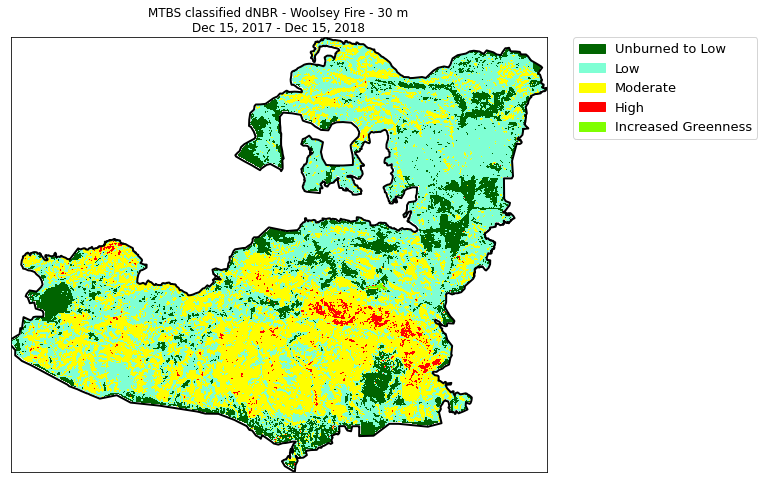

In [4]:
# Make dNBR plot
labels = [
    "Unburned to Low",
    "Low",
    "Moderate",
    "High",
    "Increased Greenness"
]

colors = [
    "#006400",
    "#7FFFD4",
    "#FFFF00",
    "#FF0000",
    "#7FFF00"
]

# Draw plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_bands(dnbr_classified,
           cmap=ListedColormap(colors),
           vmin=1,
           vmax=5,
           title=("MTBS classified dNBR - Woolsey Fire - 30 m\n"
                  "Dec 15, 2017 - Dec 15, 2018"),
           cbar=False,
           scale=False,
           ax=ax)
woolsey_fire.plot(ax=ax, edgecolor="k", facecolor="none", linewidth=2)

# Draw legend
ep.draw_legend(im_ax=ax.get_images()[0],
               classes=range(5),
               titles=labels)

__Figure 4. MTBS Difference of Normalized Burn Ratio, 2017-18. These data are indicative of burn severity.__

## Workflow

We plan to use the random-forest machine-learning algorithm to evaluate how vegetation mortality affects burn severity. As such, we must first select the explanatory and response variables we want to model.In order to characterize the relationships between the available data, we are analyzing pairwise linear regressions.

We plan to evaluate two aspects of the pre- and post-fire system, both of which have obvious response variables:

+ Drought-resistance of different vegetation communities (response=FAL or dFAL)
+ Burn severity (response=dNBR)

Selecting explanatory variables requires a closer look at the vegetation and climate data. Each data source (described in more detail below) provides data in a different coordinate reference system (CRS), resolution, and extent, so we projected all data to the same CRS, resampled it to the same resolution, and cropped it to the same extent before beginning our analysis. The reprojected data contains roughly 1.6 million pixels inside the Woolsey Fire scar. To reduce computation times, we've filtered the data using two approaches:

+ Creating training and validation datasets of a few thousand pixels a piece inside the fire scar. We will ultimately use these subsets to train and validate the random-forest model, but are currently using them to evaluate linear regressions.
+ Aggregating high resolution data into 4-km blocks.

## Preliminary results

The pixel data, even when reduced to a sample of a few thousand pixels, is very noisy. For analyses of drought resistance, a major source of noise is the low resolution of the climate data. Each 4-km block of climate data corresponds to thousands of points in the higher-resolution datasets, which span a range of vegetation types, slopes, and elevations, producing large spreads of data (Fig. 5). But even the fire data is noisy at the scale of the full dataset or individual vegetation communities. We plan to address this problem, as described below in the Future Work section.

The 4-km aggregate data has been more useful for finding correlations, but so far the only relationships that we've tested are between dNBR and FAL/dFAL. Burn severity correlates positively with (1) vegetation mortality in 2013 and (2) area of vegetation that died between 2013 and 2014.


## Future work

We plan to address the noise in the sampled data by looking at specific subsets. So far, we have only looked at individual vegetation communities across the full study area, but we plan to combine community data with climate, elevation and slope data to identify subsets that respond clearly to drought or fire. We also plan to refine the aggregation methods mentioned above and investigate additional variables using the 4-km blocks.

Once we've selected the explanatory variables, we will begin running random-forest models to evaluate how well each explanatory value predicts a response.


## References